In [1]:
from src.models import Exponential_Model
from src.criterion import right_censored
from src.load_data import load_datasets,load_dataframe
from src.utils import train

from torch.optim import Adam
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter

from tqdm import tqdm
import pandas as pd

In [2]:
dataset_train,dataset_test = load_datasets("TRACE",test_size=0.2)

In [3]:
input_dims = dataset_train.tensors[0].shape[1]
output_dim = 1
hidden_dim = [15]
batch_size = 32
print_every = 50
lr = 1e-5

In [4]:
dataloader_train = DataLoader(dataset_train,batch_size=batch_size,shuffle=True)
dataloader_test = DataLoader(dataset_test,batch_size=batch_size,shuffle=False)

dataset_train.tensors[0].shape

torch.Size([1502, 10])

In [5]:
clf = Exponential_Model(input_dim=input_dims,hidden_layers=hidden_dim,output_dim=output_dim)

optimizer = Adam(clf.parameters(),lr=1e-3)
criterion = right_censored

In [6]:
epochs,train_loss = train(model=clf,dataloader_train=dataloader_train,optimizer=optimizer,criterion=criterion,print_every=print_every,epochs=200)

Epoch 50, LL=2072.983
Epoch 100, LL=2040.128
Epoch 150, LL=2032.341
Epoch 200, LL=2025.444
Finished Training


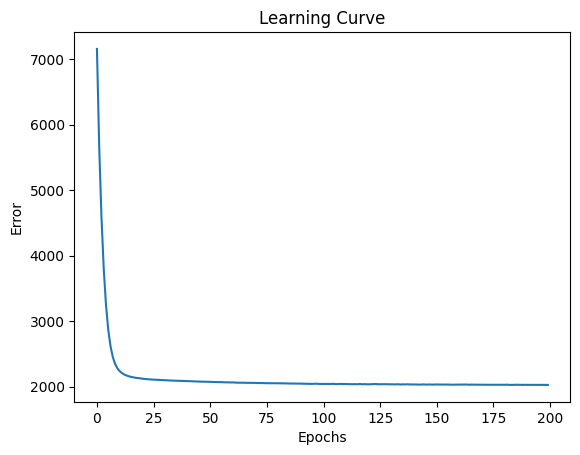

In [7]:
plt.plot(epochs,train_loss)
plt.ylabel("Error"); plt.xlabel("Epochs")
plt.title("Learning Curve")
plt.show()

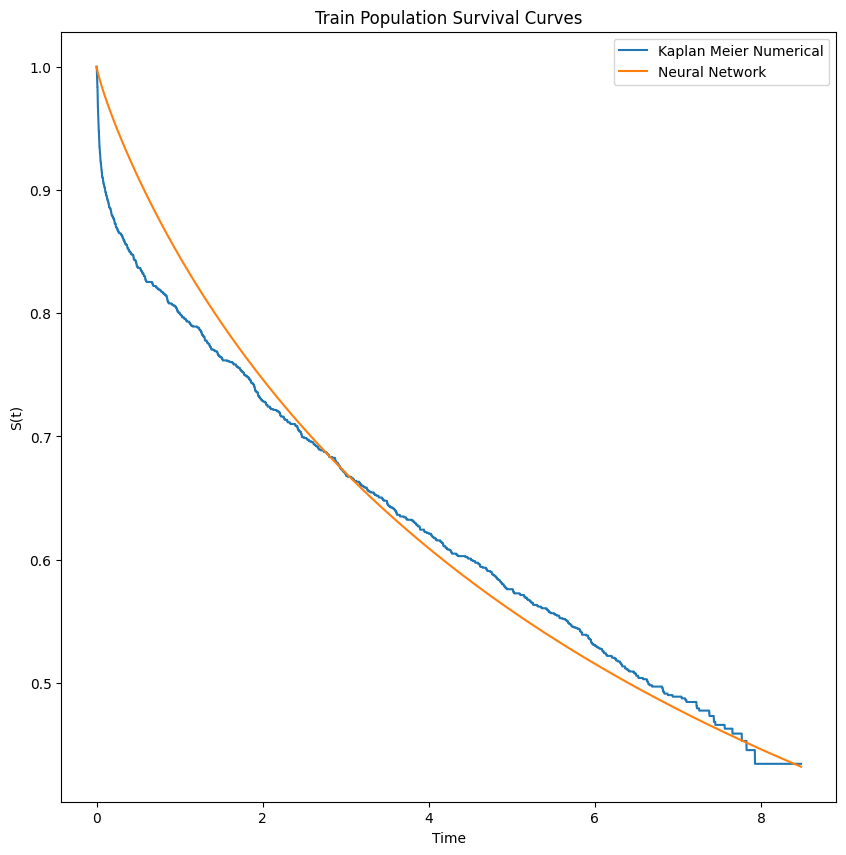

In [8]:
X_train,T_train,E_train = dataloader_train.dataset.tensors
t = torch.linspace(0,T_train.max(),10000)

St_given_x = clf.survival_qdf(X_train,t)

kmf = KaplanMeierFitter()
kmf.fit(durations=T_train,event_observed=E_train)
St_kmf  = kmf.predict(times=t.ravel().numpy())

plt.figure(figsize=(10,10))
plt.plot(t,St_kmf)
plt.plot(t,St_given_x.mean(0))
plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical","Neural Network"])
plt.title("Train Population Survival Curves")
plt.show()

100%|██████████| 100/100 [00:34<00:00,  2.91it/s]


Text(0.5, 1.0, 'Individual Survival Curves Train')

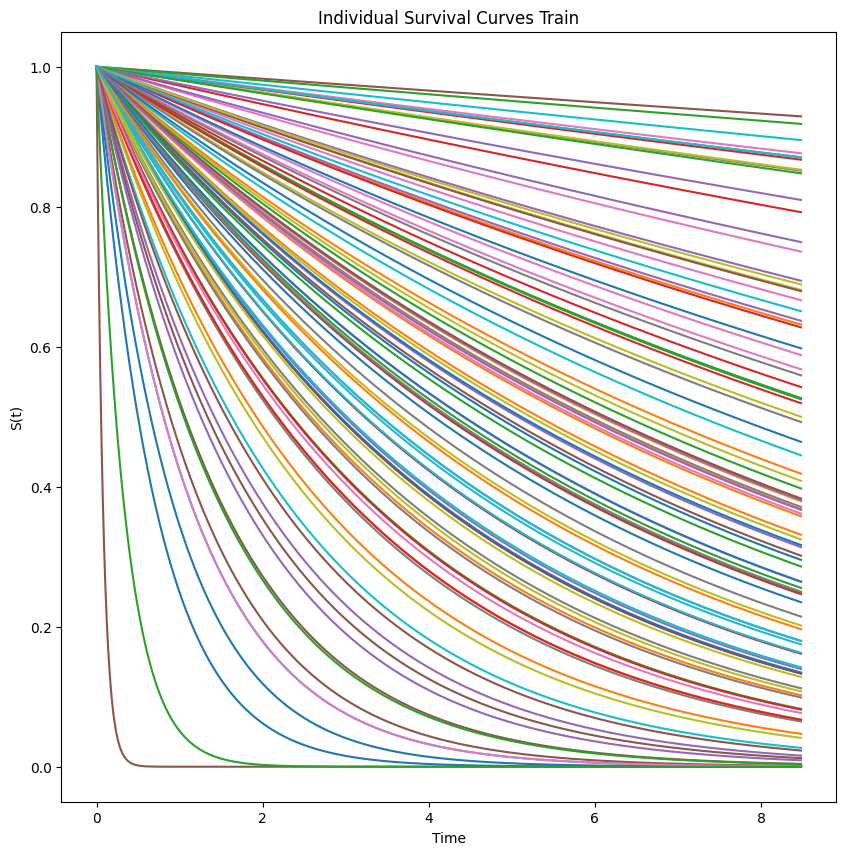

In [9]:
plt.figure(figsize=(10,10))
for Sti in tqdm(St_given_x[:100]):
    plt.plot(t,Sti)
plt.ylabel("S(t)"); plt.xlabel("Time")
plt.title("Individual Survival Curves Train")

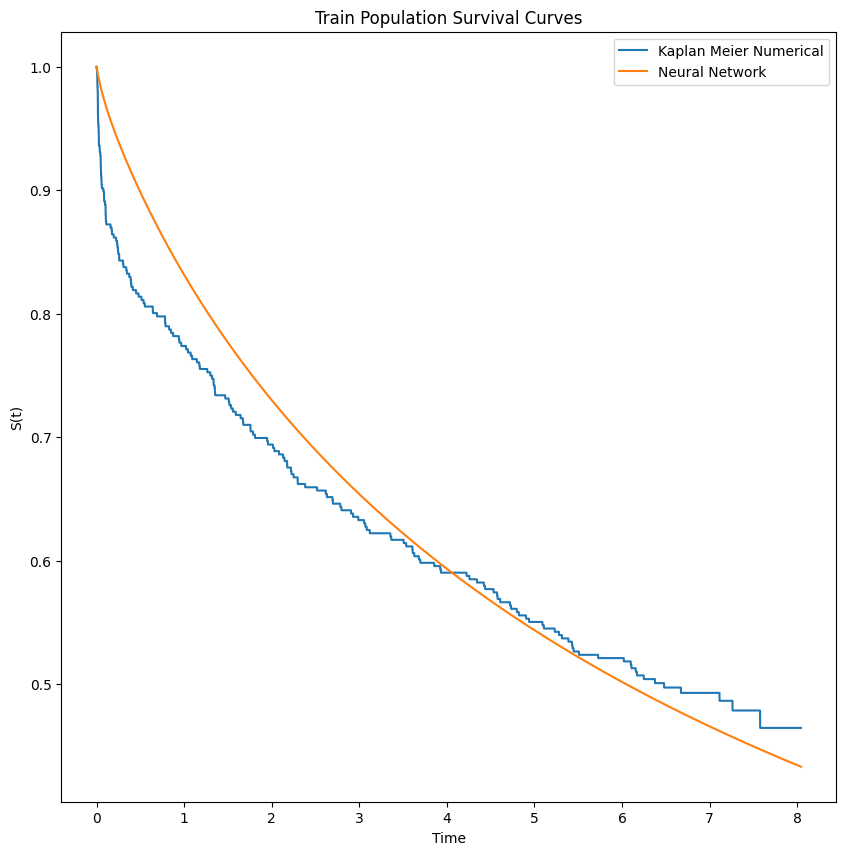

In [10]:
X_test,T_test,E_test = dataloader_test.dataset.tensors
t = torch.linspace(0,T_test.max(),10000)

St_given_x = clf.survival_qdf(X_test,t)

kmf = KaplanMeierFitter()
kmf.fit(durations=T_test,event_observed=E_test)
St_kmf = kSt_kmf = kmf.predict(times=t.ravel().numpy())

plt.figure(figsize=(10,10))
plt.plot(t,St_kmf)
plt.plot(t,St_given_x.mean(0))
plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical","Neural Network"])
plt.title("Train Population Survival Curves")
plt.show()

In [11]:
print("Train CI",concordance_index(event_times=T_train,predicted_scores=-clf.rate_logit(X_train).detach(),event_observed=E_train))
print("Train CI",concordance_index(event_times=T_test,predicted_scores=-clf.rate_logit(X_test).detach(),event_observed=E_test))

Train CI 0.7559469194039947
Train CI 0.725382643444168


In [12]:
cph = CoxPHFitter()
df_train,df_test = load_dataframe(ds_name="TRACE",drop_first=True,normalize=True,test_size=0.2)

cph.fit(df_train,duration_col="time",event_col="event",robust=True)

<lifelines.CoxPHFitter: fitted with 1502 total observations, 736 right-censored observations>

In [13]:
print("Train CI",cph.score(df_train,"concordance_index"))
print("Test CI",cph.score(df_test,"concordance_index"))

Train CI 0.74030748183475
Test CI 0.7415464468361194
